/var/folders/sn/b17hblzd5fn2bsjtr86f7c8h0000gn/T/ipykernel_81785/2242084722.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("jet", len(df["quality"].unique()))
/var/folders/sn/b17hblzd5fn2bsjtr86f7c8h0000gn/T/ipykernel_81785/2242084722.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[1, 0].scatter(group['Principal Component 1'], group['Principal Component 2'], label=quality, cmap=cmap, edgecolors='k')
/var/folders/sn/b17hblzd5fn2bsjtr86f7c8h0000gn/T/ipykernel_81785/2242084722.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = axes[1, 1].scatter(group['Component 1'], group['Component 2'], label=quality, cmap=cmap, edgecolors='k')


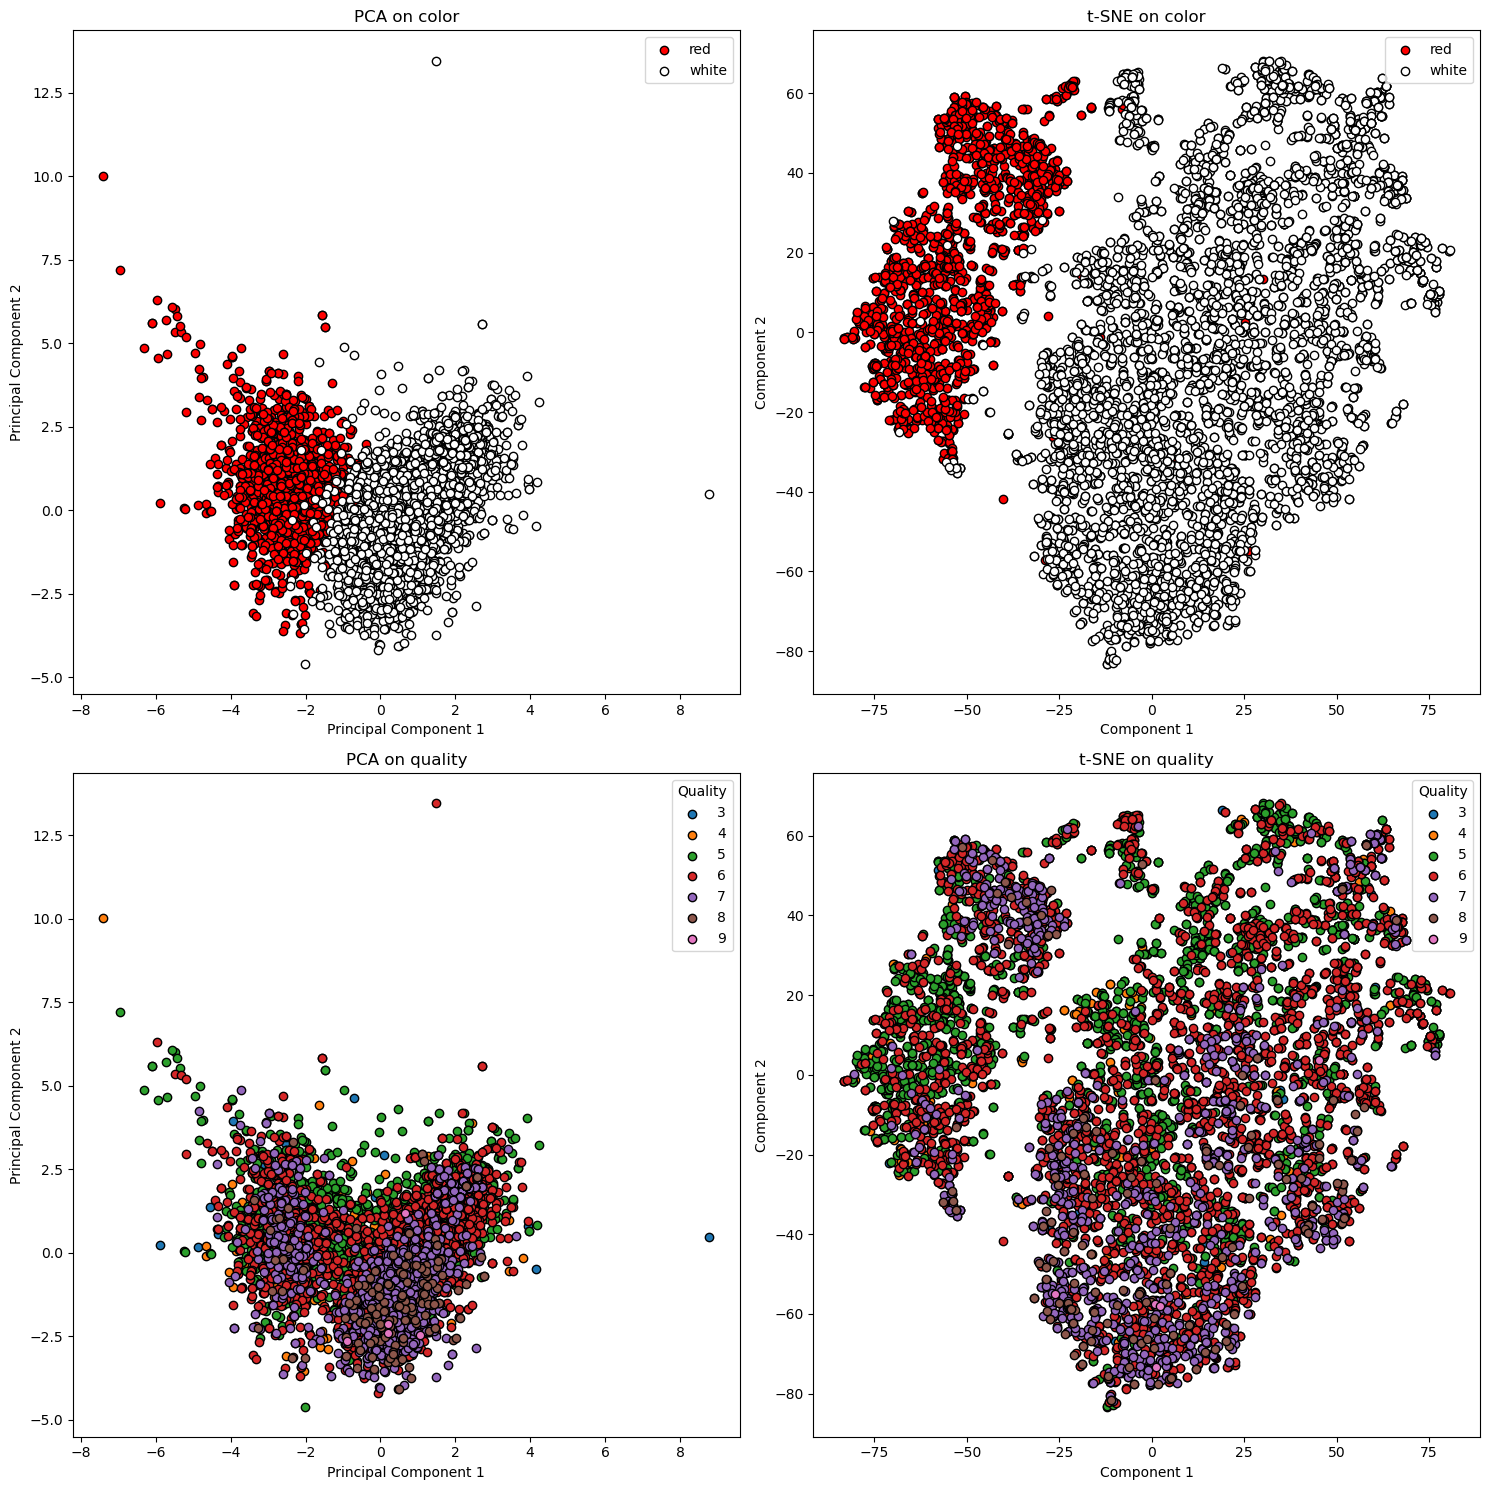

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('wine.csv')
features = ['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol']

x = df.loc[:, features].values

x = StandardScaler().fit_transform(x)

# Run PCA
pca = PCA(n_components=2)

# Fit and transform the data 'x' to 2D
principalComponents = pca.fit_transform(x)

# Convert the PCA results into a DataFrame
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])

# Combine the PCA results with 'color' and 'quality' columns from 'df'
finalDf = pd.concat([principalDf, df[['color', 'quality']]], axis=1)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, early_exaggeration=12)

# Fit and transform the data 'x' using t-SNE
tsne_results = tsne.fit_transform(x)

# Convert the t-SNE results into a DataFrame
tsneDf = pd.DataFrame(data=tsne_results, columns=['Component 1', 'Component 2'])

# Combine the t-SNE results with 'color' and 'quality' columns from 'df'
finalTsneDf = pd.concat([tsneDf, df[['color', 'quality']]], axis=1)


# Create a 2x2 subplot for visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# top left : PCA & color
colors = {'red': 'r', 'white': 'w'}
for color, group in finalDf.groupby('color'):
    axes[0, 0].scatter(group['Principal Component 1'], group['Principal Component 2'], c=colors[color], label=color, edgecolors='k')
    
# Configure the plot settings
axes[0, 0].set_title('PCA on color')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Principal Component 1')
axes[0, 0].set_ylabel('Principal Component 2')

# top right : PCA & quality
cmap = plt.cm.get_cmap("jet", len(df["quality"].unique()))
for quality, group in finalDf.groupby('quality'):
    sc = axes[1, 0].scatter(group['Principal Component 1'], group['Principal Component 2'], label=quality, cmap=cmap, edgecolors='k')

# Configure the plot settings
axes[1, 0].set_title('PCA on quality')
axes[1, 0].legend(title="Quality")
axes[1, 0].set_xlabel('Principal Component 1')
axes[1, 0].set_ylabel('Principal Component 2')


# down left : t-SNE & color
for color, group in finalTsneDf.groupby('color'):
    axes[0, 1].scatter(group['Component 1'], group['Component 2'], c=colors[color], label=color, edgecolors='k')
    
# Configure the plot settings
axes[0, 1].set_title('t-SNE on color')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Component 1')
axes[0, 1].set_ylabel('Component 2')


# down right: t-SNE & quality
for quality, group in finalTsneDf.groupby('quality'):
    sc = axes[1, 1].scatter(group['Component 1'], group['Component 2'], label=quality, cmap=cmap, edgecolors='k')
    
# Configure the plot settings
axes[1, 1].set_title('t-SNE on quality')
axes[1, 1].legend(title="Quality")
axes[1, 1].set_xlabel('Component 1')
axes[1, 1].set_ylabel('Component 2')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

- For distinguishing between red and white wines, t-SNE seems more effective than PCA based on the visualizations.
- Neither PCA nor t-SNE effectively distinguishes wines based on quality.

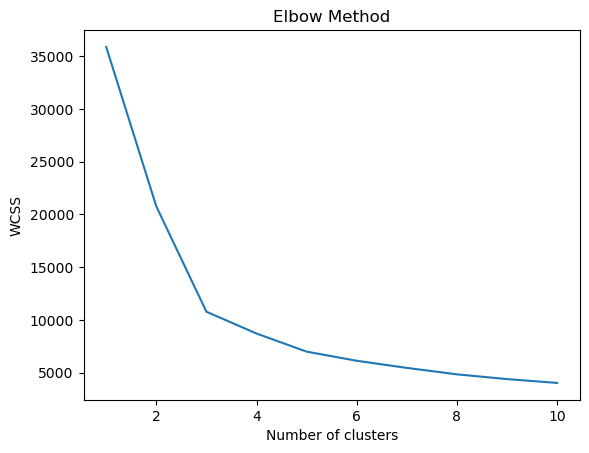

In [4]:
# Find best KMeans by Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = [] # within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(principalDf)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Elbow Method shows that the best cluster is 3, seems we can do some changes on "quality" clustering. How about we set bins at quality? 
Let "Low Quality" be 3~4, "Medium Quality" be 5-6, "High Quality" be 7-9.

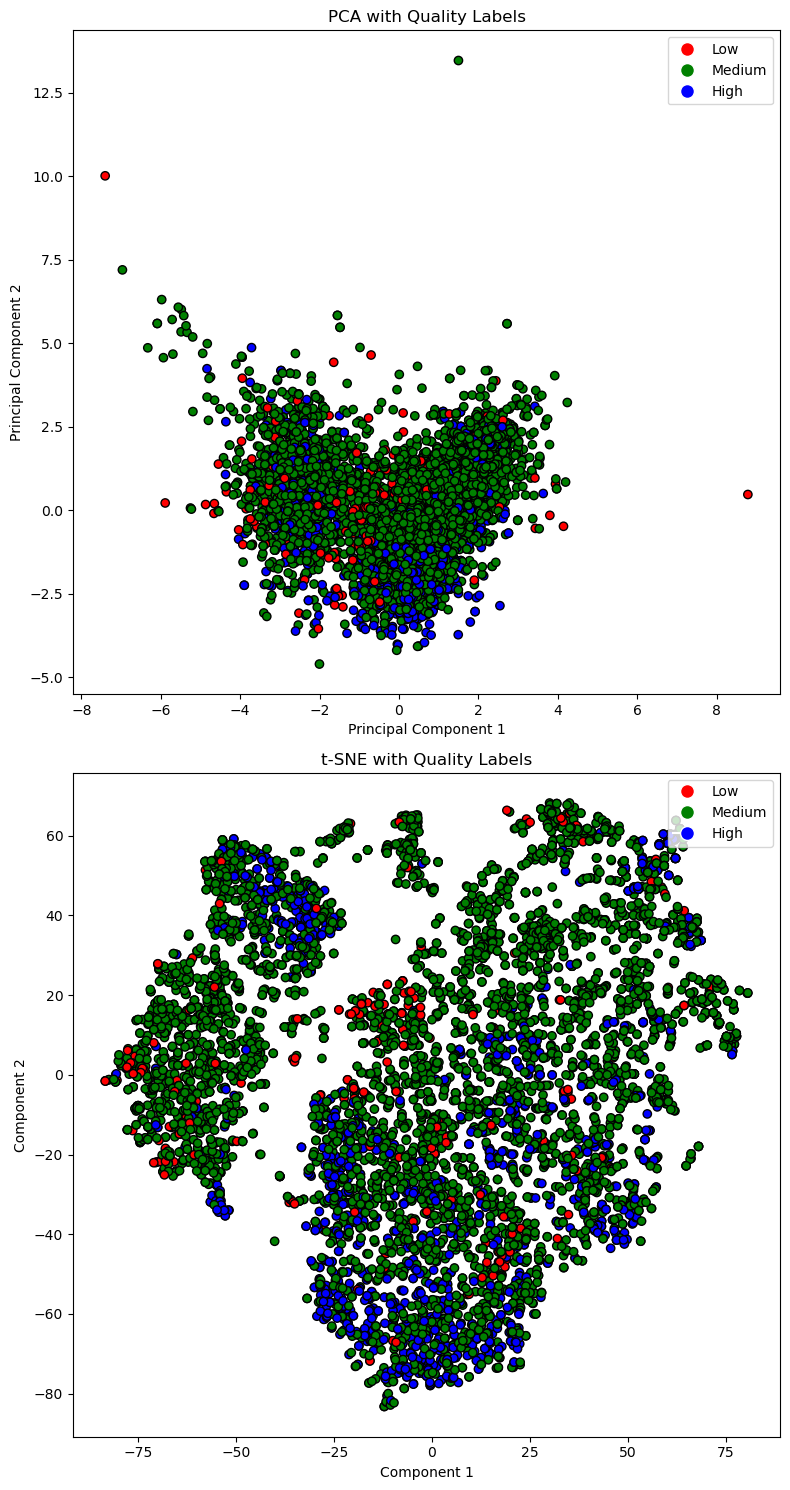

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define bins and their corresponding labels
bins = [3, 4, 6, 10]
labels = ['Low', 'Medium', 'High']

# Create a new column 'quality_label' in df based on the defined bins and labels
df['quality_label'] = pd.cut(df['quality'], bins=bins, labels=labels, include_lowest=True)

# Define a color dictionary corresponding to the labels
colors = {'Low':'red', 'Medium':'green', 'High':'blue'}

# Create a figure with two subplots arranged in a 2x1 format
fig, axes = plt.subplots(2, 1, figsize=(8, 15))

# PCA plot
axes[0].scatter(principalDf['Principal Component 1'], principalDf['Principal Component 2'], c=df['quality_label'].apply(lambda x: colors[x]), edgecolors='k')
axes[0].set_title('PCA with Quality Labels')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# t-SNE plot
axes[1].scatter(tsneDf['Component 1'], tsneDf['Component 2'], c=df['quality_label'].apply(lambda x: colors[x]), edgecolors='k')
axes[1].set_title('t-SNE with Quality Labels')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')

# Create a list for the legend indicating which color corresponds to which quality label
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Low'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Medium'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='High')
]

# Add legends to both subplots
axes[0].legend(handles=legend_elements, loc='upper right')
axes[1].legend(handles=legend_elements, loc='upper right')

# Adjust the spacing between subplots so they don't overlap
plt.tight_layout()
plt.show()


Seems that even with the quality category, t-SNE and PCA still cannot classify well. However, we can observe that the distribution in t-SNE, compared to PCA, is less compact. One could also say that quality is more suitable for t-SNE than for PCA.